Nama: Muhammad Sulthan Nasyira

Cohort-ID: MC589D5Y2486

Kelas: MC-49

dataset source: https://www.kaggle.com/datasets/lyensoetanto/vehicle-images-dataset

## Setup & Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## Dataset Path dan Generator

In [2]:
import zipfile
import os

zip_path = 'mobil.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)


['mobil']

In [22]:
total_train = train_generator.samples
total_val = val_generator.samples
total_test = test_generator.samples

total_images = total_train + total_val + total_test
print("Total gambar:", total_images)


Total gambar: 13239


In [3]:
import os
import shutil
import random

original_dataset_dir = '/content/dataset/mobil'

base_dir = '/content/dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_split = 0.7
val_split = 0.15
test_split = 0.15

for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * train_split)
    val_count = int(total * val_split)

    train_imgs = images[:train_count]
    val_imgs = images[train_count:train_count + val_count]
    test_imgs = images[train_count + val_count:]

    for subset_dir, subset_imgs in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
        class_subset_dir = os.path.join(subset_dir, class_name)
        os.makedirs(class_subset_dir, exist_ok=True)
        for img in subset_imgs:
            shutil.copy2(os.path.join(class_path, img), os.path.join(class_subset_dir, img))

print("✅ Dataset berhasil dibagi di folder:", base_dir)


✅ Dataset berhasil dibagi di folder: /content/dataset_split


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 9265 images belonging to 5 classes.
Found 1984 images belonging to 5 classes.
Found 1990 images belonging to 5 classes.


## Buat Model CNN

In [8]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,661 (169.37 MB)

 Trainable params: 44,398,661 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

## Callback dan Training

In [10]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.4747 - loss: 1.2560

290/290 ━━━━━━━━━━━━━━━━━━━━ 123s 424ms/step - accuracy: 0.4748 - loss: 1.2557 - val_accuracy: 0.5060 - val_loss: 1.1460
Epoch 2/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5558 - loss: 1.0372

290/290 ━━━━━━━━━━━━━━━━━━━━ 121s 416ms/step - accuracy: 0.5558 - loss: 1.0371 - val_accuracy: 0.6109 - val_loss: 0.9126
Epoch 3/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6169 - loss: 0.9049

290/290 ━━━━━━━━━━━━━━━━━━━━ 141s 414ms/step - accuracy: 0.6170 - loss: 0.9048 - val_accuracy: 0.6794 - val_loss: 0.7598
Epoch 4/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6752 - loss: 0.7675

290/290 ━━━━━━━━━━━━━━━━━━━━ 113s 389ms/step - accuracy: 0.6752 - loss: 0.7674 - val_accuracy: 0.7424 - val_loss: 0.6177
Epoch 5/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7192 - loss: 0.6734

290/290 ━━━━━━━━━━━━━━━━━━━━ 117s 404ms/step - accuracy: 0.7192 - loss: 0.6734 - val_accuracy: 0.7379 - val_loss: 0.5769
Epoch 6/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7568 - loss: 0.6018

290/290 ━━━━━━━━━━━━━━━━━━━━ 112s 384ms/step - accuracy: 0.7568 - loss: 0.6018 - val_accuracy: 0.7707 - val_loss: 0.5303
Epoch 7/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7673 - loss: 0.5684

290/290 ━━━━━━━━━━━━━━━━━━━━ 118s 408ms/step - accuracy: 0.7674 - loss: 0.5684 - val_accuracy: 0.7807 - val_loss: 0.5097
Epoch 8/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7881 - loss: 0.5221

290/290 ━━━━━━━━━━━━━━━━━━━━ 114s 394ms/step - accuracy: 0.7881 - loss: 0.5220 - val_accuracy: 0.7994 - val_loss: 0.4685
Epoch 9/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8029 - loss: 0.4665

290/290 ━━━━━━━━━━━━━━━━━━━━ 115s 395ms/step - accuracy: 0.8029 - loss: 0.4665 - val_accuracy: 0.8180 - val_loss: 0.4427
Epoch 10/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8154 - loss: 0.4412

290/290 ━━━━━━━━━━━━━━━━━━━━ 118s 408ms/step - accuracy: 0.8155 - loss: 0.4411 - val_accuracy: 0.8256 - val_loss: 0.4320
Epoch 11/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8355 - loss: 0.4056

290/290 ━━━━━━━━━━━━━━━━━━━━ 117s 404ms/step - accuracy: 0.8355 - loss: 0.4056 - val_accuracy: 0.8246 - val_loss: 0.4113
Epoch 12/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 109s 377ms/step - accuracy: 0.8452 - loss: 0.3792 - val_accuracy: 0.8145 - val_loss: 0.4332
Epoch 13/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8463 - loss: 0.3631

290/290 ━━━━━━━━━━━━━━━━━━━━ 117s 403ms/step - accuracy: 0.8463 - loss: 0.3632 - val_accuracy: 0.8574 - val_loss: 0.3588
Epoch 14/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8539 - loss: 0.3584

290/290 ━━━━━━━━━━━━━━━━━━━━ 120s 413ms/step - accuracy: 0.8539 - loss: 0.3583 - val_accuracy: 0.8604 - val_loss: 0.3474
Epoch 15/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 110s 381ms/step - accuracy: 0.8711 - loss: 0.3236 - val_accuracy: 0.8594 - val_loss: 0.3593
Epoch 16/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 109s 376ms/step - accuracy: 0.8860 - loss: 0.3045 - val_accuracy: 0.8569 - val_loss: 0.3907
Epoch 17/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8820 - loss: 0.2893

290/290 ━━━━━━━━━━━━━━━━━━━━ 121s 417ms/step - accuracy: 0.8820 - loss: 0.2893 - val_accuracy: 0.8654 - val_loss: 0.3455
Epoch 18/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 110s 379ms/step - accuracy: 0.8801 - loss: 0.2952 - val_accuracy: 0.8684 - val_loss: 0.3486
Epoch 19/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 112s 386ms/step - accuracy: 0.8930 - loss: 0.2787 - val_accuracy: 0.8649 - val_loss: 0.3649
Epoch 20/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 110s 381ms/step - accuracy: 0.8883 - loss: 0.2820 - val_accuracy: 0.8543 - val_loss: 0.3968
Epoch 21/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8910 - loss: 0.2705

290/290 ━━━━━━━━━━━━━━━━━━━━ 117s 404ms/step - accuracy: 0.8910 - loss: 0.2704 - val_accuracy: 0.8876 - val_loss: 0.3111
Epoch 22/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 114s 393ms/step - accuracy: 0.9014 - loss: 0.2483 - val_accuracy: 0.8634 - val_loss: 0.3808
Epoch 23/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8995 - loss: 0.2499

290/290 ━━━━━━━━━━━━━━━━━━━━ 118s 406ms/step - accuracy: 0.8996 - loss: 0.2499 - val_accuracy: 0.8972 - val_loss: 0.2920
Epoch 24/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 112s 386ms/step - accuracy: 0.9154 - loss: 0.2097 - val_accuracy: 0.8639 - val_loss: 0.4032
Epoch 25/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 142s 387ms/step - accuracy: 0.9149 - loss: 0.2116 - val_accuracy: 0.8911 - val_loss: 0.3155
Epoch 26/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9166 - loss: 0.2201

290/290 ━━━━━━━━━━━━━━━━━━━━ 150s 414ms/step - accuracy: 0.9165 - loss: 0.2201 - val_accuracy: 0.9007 - val_loss: 0.2901
Epoch 27/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 132s 379ms/step - accuracy: 0.9284 - loss: 0.1943 - val_accuracy: 0.8826 - val_loss: 0.3748
Epoch 28/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 111s 383ms/step - accuracy: 0.9322 - loss: 0.1803 - val_accuracy: 0.8916 - val_loss: 0.3326
Epoch 29/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 109s 377ms/step - accuracy: 0.9286 - loss: 0.1851 - val_accuracy: 0.9012 - val_loss: 0.2956
Epoch 30/30
290/290 ━━━━━━━━━━━━━━━━━━━━ 111s 382ms/step - accuracy: 0.9273 - loss: 0.1934 - val_accuracy: 0.9062 - val_loss: 0.3255


## Evaluasi

In [11]:
loss, acc = model.evaluate(val_generator)
print("Akurasi pada validation set: {:.2f}%".format(acc * 100))


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9111 - loss: 0.3619
Akurasi pada validation set: 90.62%


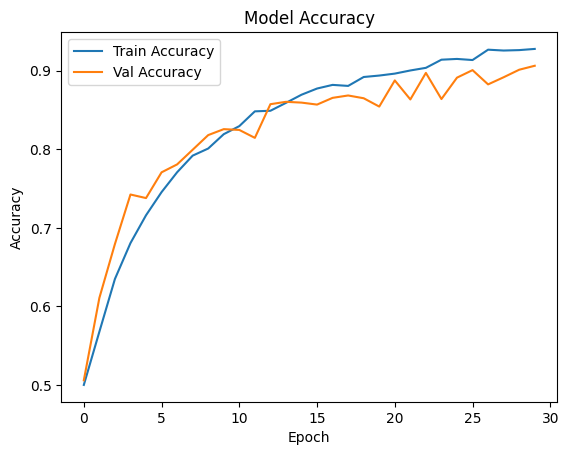

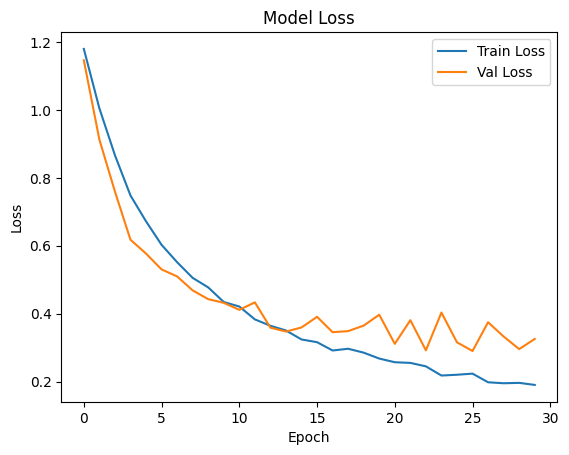

In [13]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Menyimpan output hasil model untuk Inference

In [12]:
model.save('saved_model/mobil_classifier.h5')

In [15]:
# Simpan ke format SavedModel
tf.saved_model.save(model, 'saved_model')

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Install TensorFlow.js Converter
!pip install tensorflowjs

# Konversi ke TFJS
!tensorflowjs_converter --input_format=tf_saved_model saved_model/ tfjs_model/


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-07 12:46:08.989037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746621969.009305   33116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

## Inference

satu gambar


In [17]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('saved_model/mobil_classifier.h5')

img_path = '/content/test_images/van.jpg'

img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

class_names = ['citycar', 'sedan', 'suv', 'truck', 'van']

print(f"Gambar diprediksi sebagai: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
Gambar diprediksi sebagai: van


satu folder

In [19]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('saved_model/mobil_classifier.h5')

img_height, img_width = 224, 224

folder_path = '/content/test_images/'

class_names = ['citycar', 'sedan', 'suv', 'truck', 'van']

img_list = []
img_paths = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(folder_path, filename)
        img_paths.append(full_path)

        img = image.load_img(full_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img) / 255.0
        img_list.append(img_array)

imgs_array = np.array(img_list)

predictions = model.predict(imgs_array)

for idx, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)
    print(f"Gambar {os.path.basename(img_paths[idx])} diprediksi sebagai: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Gambar suv.jpg diprediksi sebagai: suv
Gambar van.jpg diprediksi sebagai: van
Gambar truck.jpg diprediksi sebagai: truck
Gambar citycar.jpg diprediksi sebagai: citycar
Gambar sedan.jpg diprediksi sebagai: sedan


menggunakan visualisasi gambar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


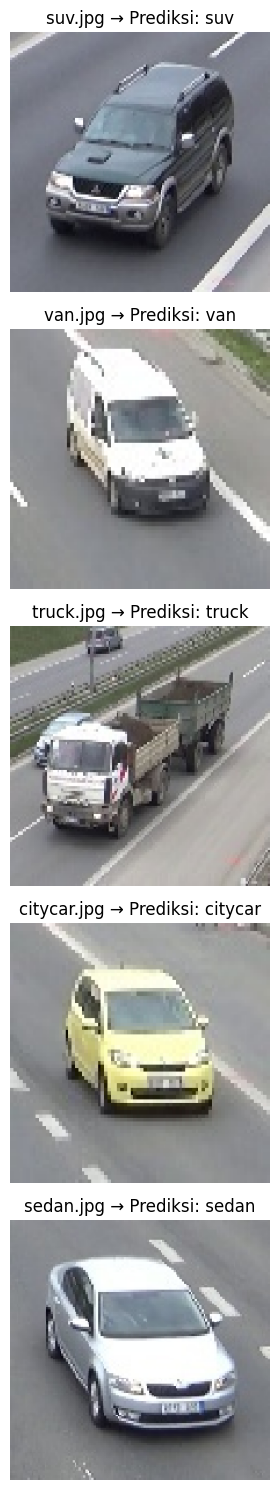

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('saved_model/mobil_classifier.h5')

img_height, img_width = 224, 224

folder_path = '/content/test_images/'

class_names = ['citycar', 'sedan', 'suv', 'truck', 'van']

img_list = []
img_paths = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(folder_path, filename)
        img_paths.append(full_path)
        img = image.load_img(full_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img) / 255.0
        img_list.append(img_array)

imgs_array = np.array(img_list)

predictions = model.predict(imgs_array)

plt.figure(figsize=(15, len(predictions) * 3))
for idx, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)
    plt.subplot(len(predictions), 1, idx + 1)
    img = image.load_img(img_paths[idx], target_size=(img_height, img_width))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{os.path.basename(img_paths[idx])} → Prediksi: {class_names[predicted_class]}")
plt.tight_layout()
plt.show()
